#  I. A few statistics on the data

In [57]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


file = 'Sample_data/MI-2013-11-04_processed.csv'

d = pd.read_csv(file, sep = '\t')
d.drop("Time",axis=1,inplace=True)
d.set_index(["Square","Month","Day","WDay","Hour"],inplace=True)
d.head(5)

SMSin     SMSout    Callin   Callout  \
Square Month Day WDay Hour                                             
5560   1     1   3    0      7.340430   7.362232  1.130827  2.917604   
                      0     11.827146  14.324700  4.319056  1.822042   
                      0      7.540386   5.793828  3.292871  3.252356   
                      0      4.658653   4.768099  3.790653  2.993384   
                      0      4.061313  12.045884  3.712321  3.511535   

                              Internet  Charge  
Square Month Day WDay Hour                      
5560   1     1   3    0     523.505147       1  
                      0     257.535138       0  
                      0     253.266168       0  
                      0     231.945013       0  
                      0     189.345856       0

### 1. Intensity by hour during a day

/home/cgaydon/Ressources/anaconda3/envs/Milano/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


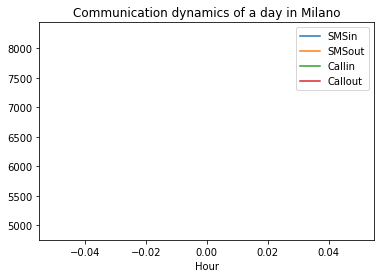

In [59]:
dHour = d.groupby(level = ["Hour"]).sum()
dHour.plot(y = ["SMSin","SMSout","Callin","Callout"], title = "Communication dynamics of a day in Milano")

/home/cgaydon/Ressources/anaconda3/envs/Milano/lib/python3.5/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


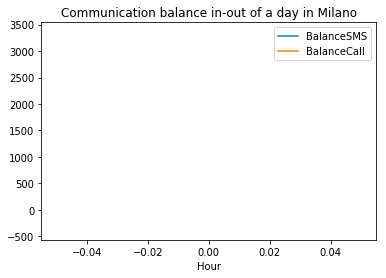

In [55]:
dHour["BalanceSMS"] = dHour["SMSin"]- dHour["SMSout"]
dHour["BalanceCall"] =  dHour["Callin"]- dHour["Callout"]
#dHour.head
dHour.plot(y = ["BalanceSMS","BalanceCall"], use_index=True, title = "Communication balance in-out of a day in Milano")

If the data is considered exhaustive, would this means that Milano's inhabitant mostly sms outside of their city, and are called from outside ?

### Intensity by hour during a week

later : we need to load seven different txt files into one to get this, as a file = a day... 

TODO : preprocess all MI files without header, stack them, add header, and save.

### 2. Intensity by square

In [ ]:
dSquare = d.groupby(level = ["Square"]).sum()
dSquare.reset_index("Square",inplace=True)
dSquare['j'] = dSquare["Square"]%100
dSquare['i'] = ((dSquare["Square"]-dSquare["j"])/100).apply(lambda x : int(x))
dSquare.head()

In [ ]:
dSquare["SMS"] = dSquare["SMSin"]+dSquare["SMSout"]
dSquare["Call"] = dSquare["Callin"] + dSquare["Callout"]
for label in ["SMS","Call"]:
    fig, (ax, ax2)=plt.subplots(ncols=2)
    ax.set_title("Tripcolor of Milano : "+label)
    ax.tripcolor(dSquare["i"], dSquare["j"], dSquare[label])
    ax2.set_title("Tricontour of Milano : " +label)
    ax2.tricontourf(dSquare["i"], dSquare["j"], dSquare[label])

    plt.show()

# Exploring Mi to Mi data

In [51]:
from preprocess_tools import *
file = 'Sample_data/decemberMI2MI/MItoMI-2013-12-01.txt'
#file = "Sample_data/decemberMI2MI/Mi-graph.txt"
fileout = file[:-4]+'-Pregel.txt'
d = pd.read_csv(file, sep = '\t', names = ["Time", "Id1", "Id2", "Pow"])
print("Imported")
d = d[d["Id1"].apply(keep_a_square) & d["Id2"].apply(keep_a_square)]
print("filtered")
d.drop("Time",axis=1,inplace=True)
d.set_index(["Id1", "Id2"],inplace=True)
d.head(5)

Imported


KeyboardInterrupt: 

In [ ]:
dPow = d.groupby(level = ["Id1", "Id2"]).sum()
dPow.reset_index(["Id1", "Id2"],inplace=True)
print(dPow.head(5))
print(dPow.shape)

In [ ]:
dPow.to_csv(path_or_buf = fileout)

# Processing the 5560 square

In [ ]:
import os
from preprocess_tools import *
ori_path = "MI_data/"
next_path = "5560"
original_dir = os.listdir(ori_path)
next_dir = os.listdir(next_path)

for index,file_ori in enumerate(original_dir):
    print("["+str(index+1)+"/"+str(len(original_dir))+"]")
    file_target = next_path + "/"+next_path+"_"+file_ori
    if next_path+"_"+file_ori not in next_dir:
        geo_filter_a_MI(ori_path+file_ori,file_target)

In [ ]:
import pandas as pd
d = pd.DataFrame()
next_path = "5560"
next_dir = os.listdir(next_path)
ori_path = "Sample_data/MI_November/"
if next_path+"_all.csv" not in next_dir:
    for file in next_dir:
        if file != next_path+"_all.csv":
            sub = pd.read_csv(next_path+"/"+file,sep="\t")
            print(sub.shape)
            d = pd.concat([d,sub])
d.to_csv(next_path+'/'+next_path+"_all.csv", index = False,sep="\t")

# III. Learning on preprocessed MI data

In [54]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
file = 'data/MI_squares/5560/5560_all.csv'
d = pd.read_csv(file, sep = '\t')
d.head(2)

,Time,Square,SMSin,SMSout,Callin,Callout,Internet,Month,Day,Hour,WDay,Charge
0,2305434.0,5560,22.816267,18.785421,16.701241,14.658665,524.403966,1,1,0,3,1
1,2305435.0,5560,25.405827,13.824837,6.816121,11.770350,643.835036,1,1,0,3,1


### a) Basés sur []() nous transformons les TS pour un usage supervisé.

In [3]:
from sklearn.preprocessing import MinMaxScaler
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
file = 'data/MI_squares/5560/5560_all.csv'
dataset = pd.read_csv(file, sep = '\t')
dataset.drop("Square",axis=1,inplace=True)
dataset.set_index("Time",inplace=True)
values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict (i.e. hour, etc)
last_col = reframed.shape[1]-1
reframed.drop(reframed.columns[[last_col,last_col-1,last_col-2,last_col-3,last_col-4]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.090339,0.083326,0.111412,0.091729,0.257814,0.0,0.0,0.0,0.0,1.0,0.100592,0.057386,0.045470,0.073655,0.322203
2,0.100592,0.057386,0.045470,0.073655,0.322203,0.0,0.0,0.0,0.0,1.0,0.084342,0.096527,0.065623,0.041206,0.232283
3,0.084342,0.096527,0.065623,0.041206,0.232283,0.0,0.0,0.0,0.0,1.0,0.075887,0.029502,0.031394,0.086704,0.232803
4,0.075887,0.029502,0.031394,0.086704,0.232803,0.0,0.0,0.0,0.0,1.0,0.042096,0.025386,0.029319,0.052531,0.202387
5,0.042096,0.025386,0.029319,0.052531,0.202387,0.0,0.0,0.0,0.0,1.0,0.071965,0.020042,0.006863,0.110020,0.194925


### b) On divise en jeu train et jeu validation 

In [90]:
values = reframed.values
n_ten_min = int((6*24*60)*0.85) #85% vs 15% 
train = values[:n_ten_min, :]
test = values[n_ten_min:, :]
# split into input and outputs
train_X, train_y = train[:, :-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7344, 1, 10) (7344, 5) (1521, 1, 10) (1521, 5)


In [ ]:
values = reframed.values
n_ten_min = int((6*24*60)*0.85) #85% vs 15% 
train = values[:n_ten_min, :]
test = values[n_ten_min:, :]
# split into input and outputs
train_X, train_y = train[:, :-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((1,train_X.shape[0], train_X.shape[1]))
test_X = test_X.reshape((1,test_X.shape[0], test_X.shape[1]))

train_y = train_y.reshape((1,train_y.shape[0], train_y.shape[1]))
test_y = test_y.reshape((1,test_y.shape[0], test_y.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

### c) On importe keras, définissons notre architecture et entraînons le modèle

In [92]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
model.add(LSTM(80, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(5))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 7344 samples, validate on 1521 samples
Epoch 1/50
1s - loss: 0.1059 - val_loss: 0.0311
Epoch 2/50
0s - loss: 0.0554 - val_loss: 0.0204
Epoch 3/50
0s - loss: 0.0463 - val_loss: 0.0199
Epoch 4/50
0s - loss: 0.0439 - val_loss: 0.0195
Epoch 5/50
0s - loss: 0.0429 - val_loss: 0.0192
Epoch 6/50
0s - loss: 0.0421 - val_loss: 0.0190
Epoch 7/50
0s - loss: 0.0411 - val_loss: 0.0188
Epoch 8/50
0s - loss: 0.0403 - val_loss: 0.0186
Epoch 9/50
0s - loss: 0.0395 - val_loss: 0.0184
Epoch 10/50
0s - loss: 0.0385 - val_loss: 0.0182
Epoch 11/50
0s - loss: 0.0376 - val_loss: 0.0180
Epoch 12/50
0s - loss: 0.0370 - val_loss: 0.0179
Epoch 13/50
0s - loss: 0.0362 - val_loss: 0.0178
Epoch 14/50
0s - loss: 0.0356 - val_loss: 0.0176
Epoch 15/50
0s - loss: 0.0350 - val_loss: 0.0176
Epoch 16/50
0s - loss: 0.0346 - val_loss: 0.0175
Epoch 17/50
0s - loss: 0.0341 - val_loss: 0.0175
Epoch 18/50
0s - loss: 0.0338 - val_loss: 0.0174
Epoch 19/50
0s - loss: 0.0335 - val_loss: 0.0175
Epoch 20/50
0s - loss: 0.0333 

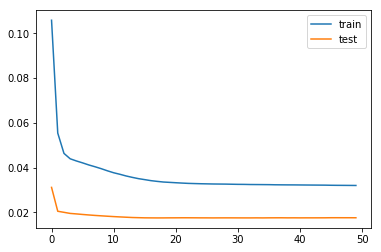

In [93]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### d) Evaluation du modèle

In [112]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
forecast = []
ground_truth = []
for index, name in enumerate(dataset.columns[:5]):   
    yhat = model.predict(test_X)
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    #forecast
    inv_yhat = np.concatenate((yhat,test_X_reshaped[:,5:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,index]
    forecast.append(inv_yhat)
    #ground truth
    inv_y = np.concatenate((test_y, test_X_reshaped[:, 5:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,index]
    ground_truth.append(inv_y)
    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = mean_absolute_error(inv_y,inv_yhat)
    print(name +' - RMSE=%.3f and MAE=%.3f' % (rmse,mae))

SMSin - RMSE=6.406 and MAE=4.253
SMSout - RMSE=7.175 and MAE=3.480
Callin - RMSE=4.228 and MAE=2.742
Callout - RMSE=6.470 and MAE=4.313
Internet - RMSE=17.845 and MAE=13.438


### e) Visualisation

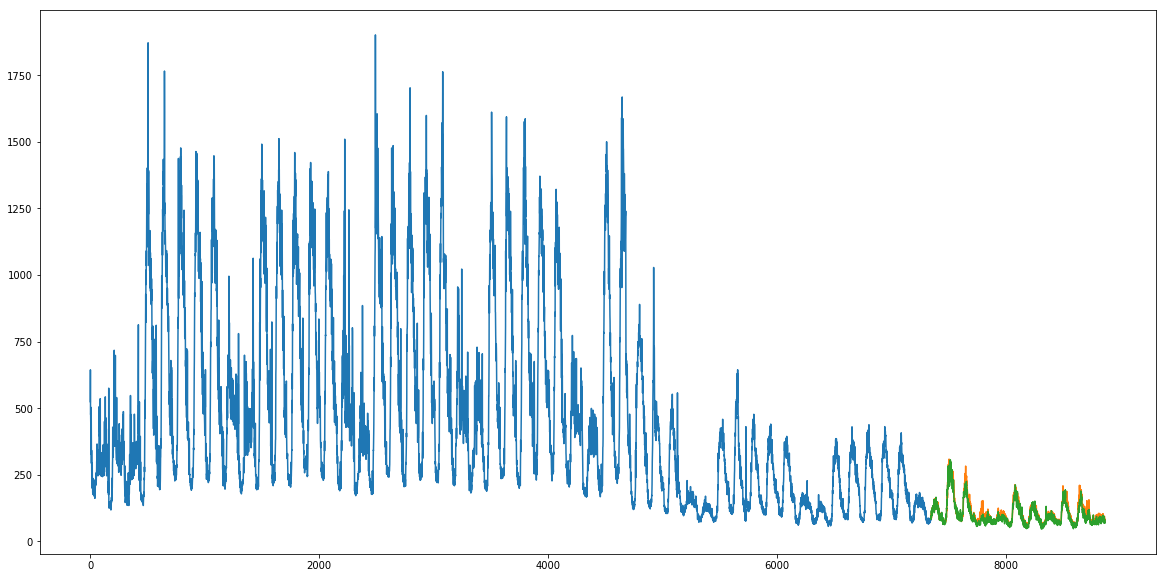

In [124]:
# reframed.plot(y = reframed.columns[-5:])
# reframed.columns
# n_ten_min
# dataset.values[["SMSin","SMSout","Callin","Callout","Internet"]]
ground_train = dataset[["SMSin","SMSout","Callin","Callout","Internet"]].values[:n_ten_min,:]
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(np.arange(train_y.shape[0]),ground_train[:,4])
plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),inv_yhat)
plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),inv_y)